In [1]:
from matplotlib.pylab import *

In [2]:
style.use(['dark_background', 'bmh'])
rc('axes', facecolor='k')            
rc('figure', facecolor='k')          
rc('figure', figsize=(10,7))         

In [3]:
def get_quad_func(minima=1, zero_at=1, one_at=0):
    t0 = (zero_at - minima)**2
    t1 = (one_at - minima)**2
    mult = 1 / (t1 - t0)
    bias = -mult*((zero_at - minima)**2)
    return lambda x: mult * (x - minima)**2 + bias

Text(0, 0.5, 'proximity cost profile')

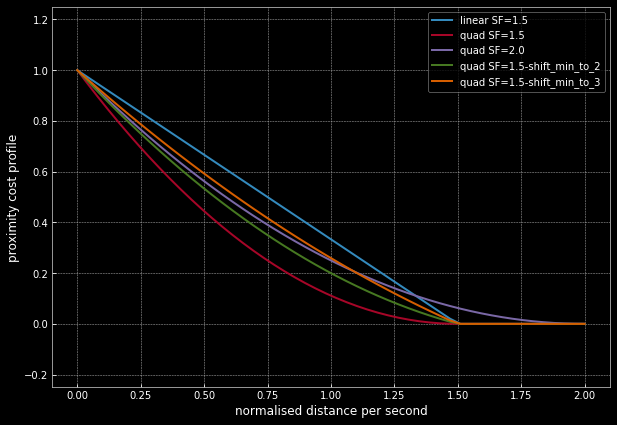

In [4]:
# Linear and quadratic proximity profile design
x = linspace(0, 2)
y = dict()
y['linear SF=1.5'] = maximum(1 - x / 1.5, 0)
y['quad SF=1.5'] = maximum((1 - x / 1.5), 0) ** 2
y['quad SF=2.0'] = (1 - x / 2.0) ** 2

# ✏️TODO: write function for analytical computation of shifts
quad_with_shift = get_quad_func(minima=2, zero_at=1.5)
y['quad SF=1.5-shift_min_to_2'] = maximum(quad_with_shift(x), 0)  # find correct values
quad_with_shift = get_quad_func(minima=3, zero_at=1.5)
y['quad SF=1.5-shift_min_to_3'] = maximum(quad_with_shift(x), 0)  # find correct values

for k in y: plot(x, y[k], label=k)

axis('equal')
legend()
xlabel('normalised distance per second')
ylabel('proximity cost profile')

In [5]:
def softmax(v, β=1):
    return log(sum(exp(β*v))) / β

In [6]:
import torch

Text(0, 0.5, '∂proximity_cost / ∂s')

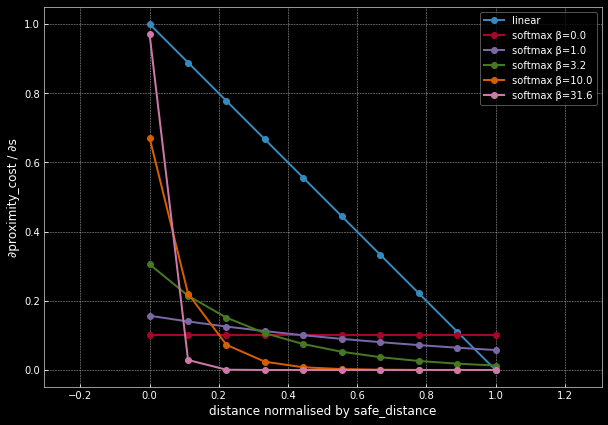

In [7]:
# Max, softmax, sum
x = torch.linspace(0, 1, 10, requires_grad=True)
y = dict()
c = 1 - x
y['linear'] = c
for e in range(-1, 4):
    β = 10 ** (e / 2)
    if e == -1: β = 0
    y[f'softmax β={β:.1f}'] = torch.softmax(β * c, dim=0)

for k in y: plot(x.detach(), y[k].detach(), '-o', label=k)

axis('equal')
legend()
xlabel('distance normalised by safe_distance')
ylabel('∂proximity_cost / ∂s')

Text(0, 0.5, '∂proximity_cost / ∂s')

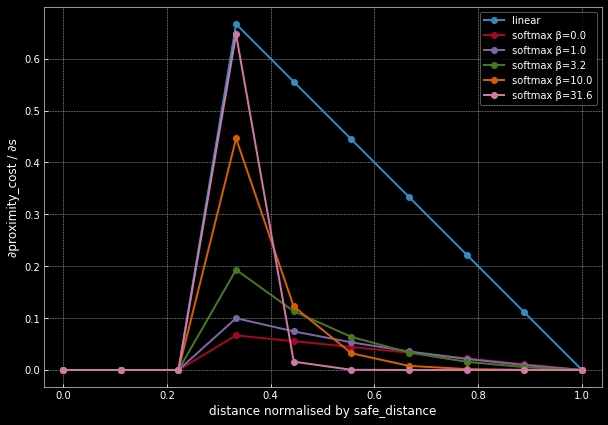

In [8]:
# Max, softmax, sum
x = torch.linspace(0, 1, 10, requires_grad=True)
y = dict()
c = 1 - x
c[:3] = 0
y['linear'] = c
for e in range(-1, 4):
    β = 10 ** (e / 2)
    if e == -1: β = 0
    y[f'softmax β={β:.1f}'] = torch.softmax(β * c, dim=0) * c

for k in y: plot(x.detach(), y[k].detach(), '-o', label=k)

axis('equal')
legend()
xlabel('distance normalised by safe_distance')
ylabel('∂proximity_cost / ∂s')

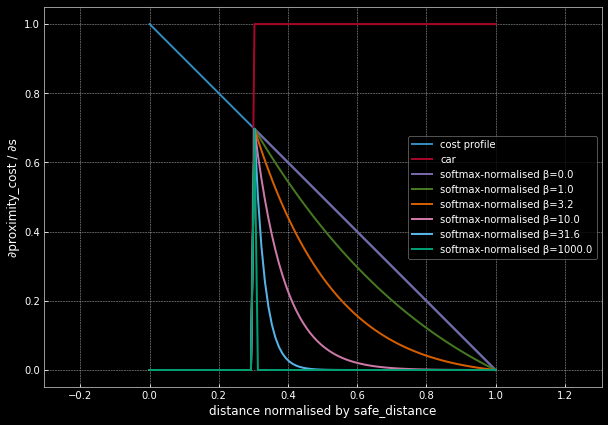

In [9]:
# Max, softmax, sum
N = 100
start = 30
x = torch.linspace(0, 1, N)
y = dict()
c = 1 - x
c[:start] = 0
y['cost profile'] = 1 - x
y['car'] = torch.zeros(N)
y['car'][start:] = 1
for e in range(-1, 5):
    β = 10 ** (e / 2)
    if e == -1: β = 0
    if e == 4: β = 1e3
    sam = torch.softmax(β * c, dim=0)
    y[f'softmax-normalised β={β:.1f}'] = sam * c / max(sam)

for k in y: plot(x, y[k], '-', label=k)

axis('equal')
legend()
xlabel('distance normalised by safe_distance')
ylabel('∂proximity_cost / ∂s')
savefig('normalised_attention.png')

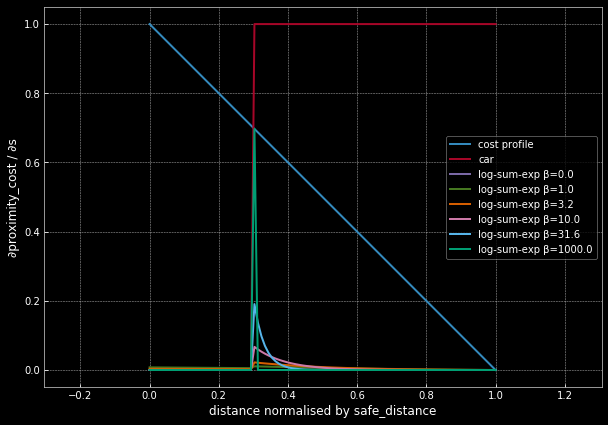

In [10]:
# Max, softmax, sum
N = 100
start = 30
x = torch.linspace(0, 1, N)
y = dict()
c = 1 - x
c[:start] = 0
y['cost profile'] = 1 - x
y['car'] = torch.zeros(N)
y['car'][start:] = 1
y['car'].requires_grad = True
for e in range(-1, 5):
    β = 10 ** (e / 2)
    if e == -1: β = 0
    if e == 4: β = 1e3
    
    cost = torch.logsumexp(β * y['cost profile'] * y['car'], dim=0 ) / β
    cost.backward()
    y[f'log-sum-exp β={β:.1f}'] = y['car'].grad.clone()
    y['car'].grad.zero_()

for k in y: 
    if hasattr(y[k],'grad'): y[k] = y[k].detach().numpy()
    plot(x, y[k], '-', label=k)

axis('equal')
legend()
xlabel('distance normalised by safe_distance')
ylabel('∂proximity_cost / ∂s')
savefig('normalised_attention.png')

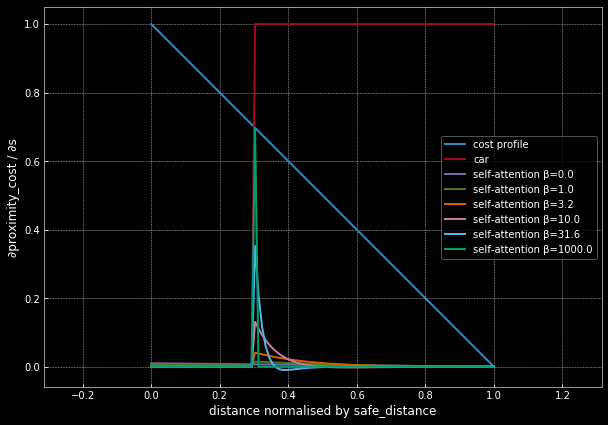

In [11]:
# Max, softmax, sum
N = 100
start = 30
x = torch.linspace(0, 1, N)
y = dict()
c = 1 - x
c[:start] = 0
y['cost profile'] = 1 - x
y['car'] = torch.zeros(N)
y['car'][start:] = 1
y['car'].requires_grad = True
for e in range(-1, 5):
    β = 10 ** (e / 2)
    if e == -1: β = 0
    if e == 4: β = 1e3
    logit = y['cost profile'] * y['car']
    cost = torch.softmax(β *logit, dim=0)*logit 
    cost.sum().backward()
    y[f'self-attention β={β:.1f}'] = y['car'].grad.clone()
    y['car'].grad.zero_()

for k in y: 
    if hasattr(y[k],'grad'): y[k] = y[k].detach().numpy()
    plot(x, y[k], '-', label=k)

axis('equal')
legend()
xlabel('distance normalised by safe_distance')
ylabel('∂proximity_cost / ∂s')
savefig('normalised_attention.png')